## Cодержание:
* [Импорт библиотек](#first)
* [Загрузка и изучение данных](#second)
* [Базовый анализ данных](#third)
* [Предобработка данных](#fourth)
* [Обучение модели](#fifth)
* [Тестирование модели](#sixth)
* [Выводы](#seventh)

## Импорт библиотек <a class="anchor" id="first"></a>

In [4]:
pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 845.0 kB/s eta 0:00:00--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os

import pandas as pd

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from typing import Optional

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import pymorphy2
from sklearn.utils import resample

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier




import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F
# TorchText development is stopped and the 0.18 release (April 2024) will be the last stable release of the library.
import torchtext




import time

import re


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device(type='cuda', index=0)

## Загрузка и изучение данных <a class="anchor" id="second"></a>

Geo Reviews Dataset 2023 - https://github.com/yandex/geo-reviews-dataset-2023


In [3]:
!wget https://github.com/yandex/geo-reviews-dataset-2023/raw/master/geo-reviews-dataset-2023.tskv

--2024-05-06 00:00:21--  https://github.com/yandex/geo-reviews-dataset-2023/raw/master/geo-reviews-dataset-2023.tskv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/yandex/geo-reviews-dataset-2023/master/geo-reviews-dataset-2023.tskv [following]
--2024-05-06 00:00:21--  https://media.githubusercontent.com/media/yandex/geo-reviews-dataset-2023/master/geo-reviews-dataset-2023.tskv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378730064 (361M) [application/octet-stream]
Saving to: 'geo-reviews-dataset-2023.tskv'

geo-reviews-dataset 100%[===================>] 361.18M   221MB/s    

In [4]:
def read_tskv(filepath: str) -> Optional[pd.DataFrame]:
    """
    Функция для чтения датасета по указанному пути

    args:
    filepath (str) - путь к файлу .tskv

    return:
    pd.DataFrame, если найден файл по указанному пути
    """
    if os.path.exists(filepath):
        try:
            list_file = []
            with open('geo-reviews-dataset-2023.tskv', 'r', encoding='utf-8') as file:
                lines = file.readlines()
                for line in lines:
                    line = line.split('\t')
                    dict_row = {}
                    for l in line:
                        l = l.split('=')
                        dict_row[l[0]] = l[1]
                    list_file.append(dict_row)
            return pd.DataFrame(list_file)
        except error as error:
            print(error)
    print(f"Файл не найден по пути {filepath}")

In [5]:
df = read_tskv('geo-reviews-dataset-2023.tskv')
df['rating'] = df['rating'].str.replace('.', '', regex=False).astype('int8')  # изначально `rating` не int
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


Изначально `rating` не int

## Базовый анализ данных <a class="anchor" id="third"></a>

Датасет в формате tskv содержит следующую информацию:

- Адрес организации (`address`)
- Название организации (`name_ru`)
- Список рубрик, к которым относится организация (`rubrics`)
- Оценка пользователя от 0 до 5 (`rating`)
- Текст отзыва (`text`)

In [6]:
def get_df_summary(df) -> pd.DataFrame:
    """
    Функция для вывода основной информации о датасете

    args:
    df (pd.DataFrame) - датасет
    """
    summary_data = []

    for col_name in df.columns:

        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        mean_value = None
        median_value = None
        std_value = None
        min_value = None
        q25_value = None
        q50_value = None
        q75_value = None
        max_value = None

        if pd.api.types.is_numeric_dtype(col_dtype):
            mean_value = df[col_name].mean()
            median_value = df[col_name].median()
            std_value = df[col_name].std()
            min_value = df[col_name].min()
            q25_value = df[col_name].quantile(0.25)
            q50_value = df[col_name].quantile(0.50)
            q75_value = df[col_name].quantile(0.75)
            max_value = df[col_name].max()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(
                10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(
                top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts,
            'mean': mean_value,
            'median': median_value,
            'std': std_value,
            'min': min_value,
            'q25': q25_value,
            'q50': q50_value,
            'q75': q75_value,
            'max': max_value,
            'distinct_values_counts': distinct_values_counts
        })


    return pd.DataFrame(summary_data)

In [7]:
get_df_summary(df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts,mean,median,std,min,q25,q50,q75,max
0,address,object,0,500000,191925,"{'Москва, Ходынский бульвар, 4': 340, 'Москва,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,name_ru,object,970,499030,148454,"{'Пятёрочка': 6030, 'Магнит': 2611, 'Красное&Б...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rating,int8,0,500000,6,"{5: 390515, 4: 41160, 1: 34351, 3: 21686, 2: 1...",4.4816,5.0,1.14625,0.0,5.0,5.0,5.0,5.0
3,rubrics,object,0,500000,31793,"{'Гостиница': 42242, 'Ресторан': 14615, 'Кафе'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,text,object,0,500000,499882,"{'Хороший магазин ': 10, 'Хороший магазин. ': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  499030 non-null  object
 2   rating   500000 non-null  int8  
 3   rubrics  500000 non-null  object
 4   text     500000 non-null  object
dtypes: int8(1), object(4)
memory usage: 15.7+ MB


In [9]:
df.describe()

,rating
count,500000.00000
mean,4.48160
std,1.14625
min,0.00000
25%,5.00000
50%,5.00000
75%,5.00000
max,5.00000


In [10]:
df['rating'].value_counts()

rating
5    390515
4     41160
1     34351
3     21686
2     12088
0       200
Name: count, dtype: int64

**Вывод**:


1. Есть пустые значения в `name_ru`.
2. `rating` со значением 0.
3. Датасет состоит из 500k отзывов.
4. Есть дубликаты у текстов отзывов.


## Предобработка данных <a class="anchor" id="fourth"></a>

Удаление пустых значений

In [11]:
df.isnull().sum()

address      0
name_ru    970
rating       0
rubrics      0
text         0
dtype: int64

In [12]:
df[df.isnull().any(axis=1)].head()

,address,name_ru,rating,rubrics,text
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",NaN,5,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе..."
5716,"Челябинская область, Златоуст, Таганайская ули...",NaN,5,Гостиница,"Гостиница действительно хорошая, удобно распол..."
5717,"Челябинская область, Златоуст, Таганайская ули...",NaN,5,Гостиница,Был здесь на кулинарном мастер-классе. Место а...
5718,"Челябинская область, Златоуст, Таганайская ули...",NaN,5,Гостиница,"Тихое место, в выходные возможно и шумно так к..."
5719,"Челябинская область, Златоуст, Таганайская ули...",NaN,5,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к..."


In [13]:
df = df.dropna()
df[df.isnull().any(axis=1)]

,address,name_ru,rating,rubrics,text


### Удаление дубликатов

In [14]:
df[df.duplicated(keep=False)]

,address,name_ru,rating,rubrics,text
124085,"Красноярск, Ястынская улица, 14",Спарта Маркет,5,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."
124087,"Красноярск, Ястынская улица, 14",Спарта Маркет,5,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."


In [15]:
df = df.drop_duplicates()
df[df.duplicated()]

,address,name_ru,rating,rubrics,text


In [16]:
df[df.duplicated(keep=False ,subset=['text','name_ru'])]

,address,name_ru,rating,rubrics,text
75191,"Волгоград, Дзержинский район, район Семь Ветро...",Wildberries,5,Пункт выдачи,Очень хороший пункт выдачи!\n
79849,"Республика Татарстан, Набережные Челны, проспе...",Пятёрочка,5,Супермаркет,Хороший магазин\n
146155,"Москва, Абрамцевская улица, 30, стр. 6",Пятёрочка,5,Супермаркет,Хороший магазин. Каждый день захожу. В зале по...
196372,"Москва, Череповецкая улица, 4А",Пятёрочка,5,Супермаркет,Хороший магазин. Каждый день захожу. В зале по...
319664,"Московская область, Дмитров, Оборонная улица, 32",Wildberries,5,Пункт выдачи,Отличный пункт выдачи! Вежливый персонал!\n
417792,"Московская область, Талдом, Калязинская улица, 49",Wildberries,5,Пункт выдачи,Отличный пункт выдачи! Вежливый персонал!\n
428631,"Москва, поселение Михайлово-Ярцевское, посёлок...",Wildberries,5,Пункт выдачи,Очень хороший пункт выдачи!\n
475708,"Ростовская область, Сальск, улица Николая Остр...",Пятёрочка,5,Супермаркет,Хороший магазин\n


In [17]:
df[df.duplicated(keep=False, subset=['text', 'name_ru'])].iloc[2]['text']

'Хороший магазин. Каждый день захожу. В зале порядок и чистота. Вежливый и общительный персонал. Фрукты овощи всегда в наличии. Постоянно хорошие скидки и акции. На кассах обслуживают быстро. При очередях оперативно открывают доп кассы. И есть кассы самообслуживания, очень удобно.\\nP.s 10 из 10\n'

In [18]:
df[df.duplicated(keep=False, subset=['text', 'name_ru'])].iloc[3]['text']

'Хороший магазин. Каждый день захожу. В зале порядок и чистота. Вежливый и общительный персонал. Фрукты овощи всегда в наличии. Постоянно хорошие скидки и акции. На кассах обслуживают быстро. При очередях оперативно открывают доп кассы. И есть кассы самообслуживания, очень удобно.\\nP.s 10 из 10\n'

Вывод: Просто одинаковые отызвы на разные адреса. Также можем наблюдать, что человек оставил абсолютно два больших одинаковых отзыва на близкие дург другу магизины Пятерочка. По хорошему удалить бы один, если бы я знал какой отзыв был написан первее.

In [19]:
df[df['rating'] == 0].head()

,address,name_ru,rating,rubrics,text
1907,"Республика Карелия, Суоярви, улица Шельшакова, 1",Гостиница Карелия,0,Гостиница,"Гостиница расположенна удобно, если отремонтир..."
2165,"Кемерово, улица Тухачевского, 12",Светофор,0,Магазин автозапчастей и автотоваров;Автоаксесс...,Это мой любимый магазин с запчастями. Можно вс...
3584,"Краснодарский край, Анапа, улица Пушкина, 30",Кубань,0,Санаторий,"Нет растительного масла для салата, нет зубочи..."
3615,"Краснодарский край, Туапсинский район, Новомих...",Счастливый Хотей,0,Гостиница,"Все довольны, и взрослые и дети.\nВкусная еда...."
6389,"Ленинградская область, Выборг, улица Мира, 8А",Атриум,0,Торговый центр,"Большой выбор, очень грамотно и удобно разложе..."


Вывод: отзывы с оценкой 0 есть хорошие и плохие. Так что удалим такие отзывы.

In [20]:
df = df[df['rating'] != 0]

In [21]:
df['rating'].value_counts()

rating
5    389692
4     41116
1     34298
3     21652
2     12071
Name: count, dtype: int64

### `city`

In [22]:
df['city'] = df['address'].map(lambda x: x.split(',')[0].lower().strip())
df['city'] = df['city'].map(lambda x: x.replace('г.', '').strip())
df['city'] = df['city'].map(lambda x: x.replace('город', '').strip())
df['city'] = df['city'].map(lambda x: x.replace('обл.', 'область').strip())

In [23]:
df.head()

,address,name_ru,rating,rubrics,text,city
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,екатеринбург
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...",московская область
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",краснодар
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,санкт-петербург
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,тверь


In [24]:
print(f"Количество уникальных городов: {len(df['city'].unique())}")

Количество уникальных городов: 404


In [25]:
df['city'].value_counts()[:100]

city
москва                             104554
санкт-петербург                     52446
московская область                  50227
краснодарский край                  29573
республика татарстан                11638
                                    ...  
республика бурятия                    706
амурская область                      641
ивановская область                    641
республика хакасия                    626
ямало-ненецкий автономный округ       623
Name: count, Length: 100, dtype: int64

Вывод: Всего получилось 404 города. Есть выбросы, но в топ 100 городов 483271 отзывов. Значит статистика по `city` будет верна.



Типы выбросов:


1.   Адрес на англиском языке.
2.   Не указан город, только улица.
3.   Название трассы.



## Описательная статистика

In [26]:
df.select_dtypes(include=['int8']).describe()

,rating
count,498829.000000
mean,4.483140
std,1.143156
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [27]:
df.describe(include=['O'])

,address,name_ru,rubrics,text,city
count,498829,498829,498829,498829,498829
unique,191595,148419,31715,498715,404
top,"Москва, Ходынский бульвар, 4",Пятёрочка,Гостиница,Хороший магазин\n,москва
freq,336,6024,42176,10,104554


In [28]:
df[df.duplicated(keep=False ,subset=['text'])]

,address,name_ru,rating,rubrics,text,city
111,"Омск, улица 10 лет Октября, 70",Пастила,3,Кафе,Цена,омск
4573,"Курганская область, Далматово, Северная улица, 2",Лыжная база,5,Лыжная база,Отличное место для отдыха.\n,курганская область
5096,"Санкт-Петербург, улица Типанова, 21",ТК Питер,5,Торговый центр;Развлекательный центр,Всё отлично!\n,санкт-петербург
7391,"Московская область, Мытищи, Рабочая улица, с18/1",Церковь Иоанна Кронштадтского в Мытищах,5,Православный храм,Все очень хорошо\n,московская область
8468,"Москва, улица Вавилова, 19",СберПервый,5,Банк,Круто\n,москва
...,...,...,...,...,...,...
482971,"Тула, Ложевая улица, 130Д",Настоящая пекарня,5,Пекарня,Вкусно\n,тула
483752,"Санкт-Петербург, Московское шоссе, 14, корп. 1",Кореана,5,Магазин автозапчастей и автотоваров,Хочу выразить благодарность за прекрасную рабо...,санкт-петербург
491429,"Московская область, Балашиха, Советская улица,...",Фото,5,Фотоуслуги;Багетные изделия;Копировальный центр,Быстро и качественно\n,московская область
491582,"Чувашская Республика, городской округ Чебоксар...",МАУК Детский парк имени космонавта А.Г. Николаева,5,Парк аттракционов,Отличное место для отдыха с детьми!\n,чувашская республика


Вывод:
1.   Много `rating` == 5.
2. Больше всего отзывов от 3 до 5, смотря на `std`.
3.   148454 уникальных мест.
4. Больше всего отзывов на магазин Пятерочка  - 6024.
5. Больше всего по адресу Москва, Ходынский бульвар, 4 (Авиапарк) - 336.
6. Больше всего оставляют отызвы на гостиницы - 42176.

## EDA

### Топ компаний по кол-во отзывов


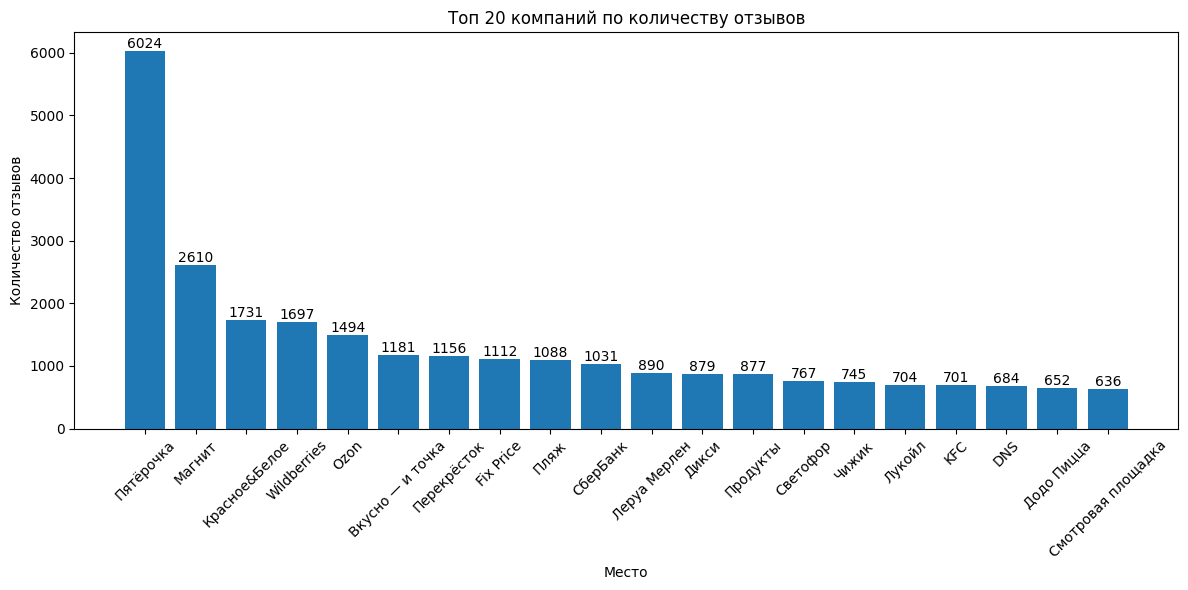

In [29]:
place_counts = df.groupby('name_ru').count()['text'].sort_values(ascending=False)

number_places = 20

plt.figure(figsize=(12, 6))
bars = plt.bar(place_counts.index[:number_places], place_counts.values[:number_places])
plt.xlabel('Место')
plt.ylabel('Количество отзывов')
plt.title('Топ 20 компаний по количеству отзывов')
plt.xticks(rotation=45)

for bar, count in zip(bars, place_counts.values[:number_places]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Вывод: крупные компании с множеством точек по всей России в топе.

### Топ компаний по рейтингу

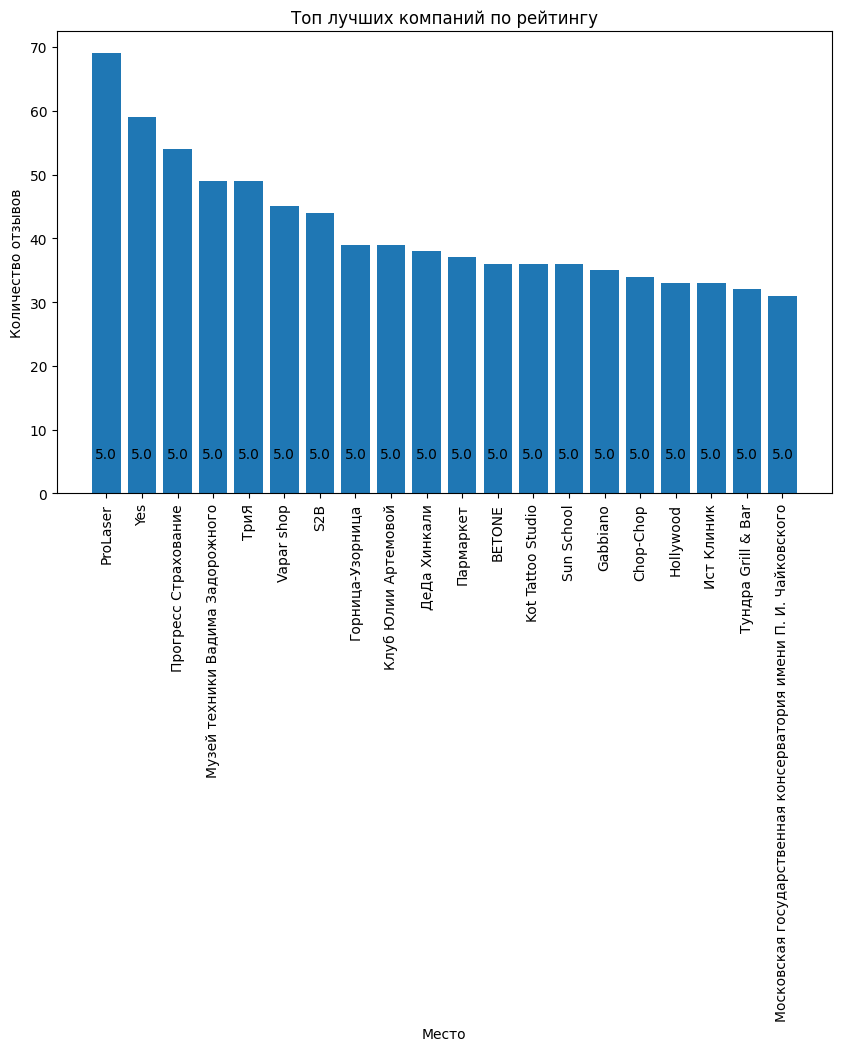

In [30]:
min_reviews = 20
number_places = 20

places = df.groupby('name_ru').count()['text'].sort_values(ascending=False)
places = places[places.values > min_reviews].index


places_grouped = df[df['name_ru'].isin(places)].groupby('name_ru')['rating'].agg(['mean', 'count'])

places_grouped = places_grouped.sort_values(by=['mean', 'count'], ascending=False)[:number_places]
places_grouped


fig, ax = plt.subplots(figsize=(10, 6))



ax.bar(places_grouped.index, places_grouped['count'])
plt.xlabel('Место')
plt.ylabel('Количество отзывов')
ax.set_title('Топ лучших компаний по рейтингу')
ax.tick_params(axis='x', rotation=90)

for i, mean in enumerate(places_grouped['mean']):
    ax.text(i, mean, str(round(mean,2)), ha='center', va='bottom')

plt.show()

Вывод: компании были првоерены по Яндекс.Каратам действительно очень хорошие места.

### Топ плохих компаний по рейтингу

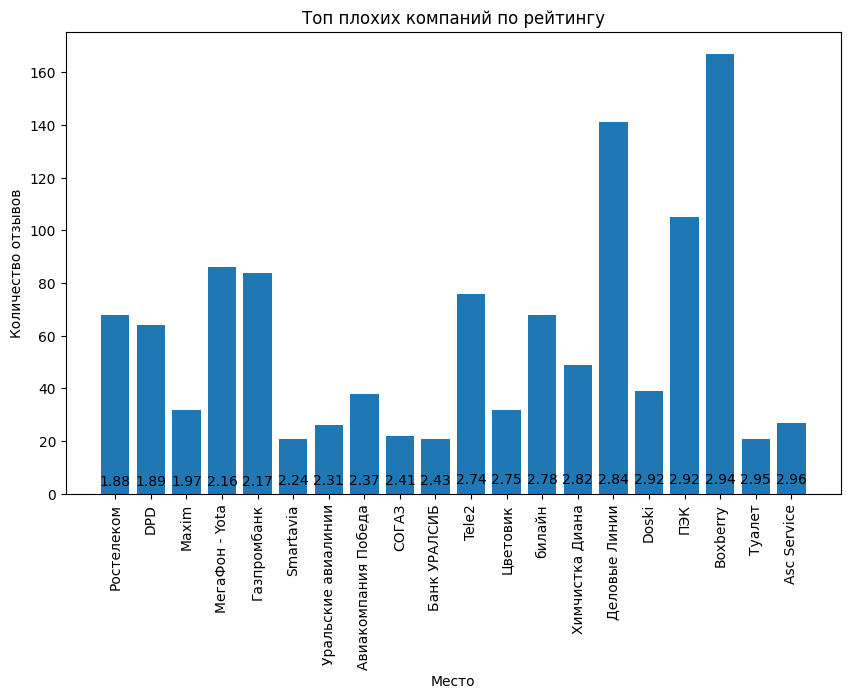

In [31]:
min_reviews = 20
number_places = 20

places = df.groupby('name_ru').count()['text'].sort_values(ascending=False)
places = places[places.values > min_reviews].index
places_grouped = df[df['name_ru'].isin(places)].groupby('name_ru')['rating'].agg(['mean', 'count'])

places_grouped = places_grouped.sort_values(by=['mean', 'count'])[:number_places]
places_grouped


fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(places_grouped.index, places_grouped['count'])
plt.xlabel('Место')
plt.ylabel('Количество отзывов')
ax.set_title('Топ плохих компаний по рейтингу')
ax.tick_params(axis='x', rotation=90)

for i, mean in enumerate(places_grouped['mean']):
    ax.text(i, mean, str(round(mean,2)), ha='center', va='bottom')

plt.show()

Вывод: среди худшего рейтинга тоже оказались крупные компании, которые предоставляют услгуги. Это может быть связано с негативными отзывами клиентов о качестве услуг, оставленными из-за неудовлетворительного опыта.

### Топ компаний по рейтингу в категориях

In [32]:
top_rubrics = df['rubrics'].value_counts()[:24].index
print(top_rubrics)

Index(['Гостиница', 'Ресторан', 'Кафе', 'Супермаркет', 'Магазин продуктов',
       'Музей', 'Быстрое питание', 'Ресторан;Кафе',
       'Супермаркет;Магазин продуктов', 'Пункт выдачи', 'Аптека',
       'Парк культуры и отдыха', 'Достопримечательность', 'Торговый центр',
       'Кафе;Ресторан', 'Стоматологическая клиника', 'База, дом отдыха',
       'Торговый центр;Развлекательный центр', 'Жилой комплекс', 'Санаторий',
       'Банк', 'Салон красоты', 'Пляж', 'АЗС'],
      dtype='object', name='rubrics')


In [33]:
min_reviews = 20
top_rubrics = df['rubrics'].value_counts()[:24].index

places = df.groupby('name_ru').count()['text'].sort_values(ascending=False)
places = places[places.values > min_reviews].index



places_grouped = df[(df['name_ru'].isin(places)) & df['rubrics'].isin(top_rubrics)].groupby(['name_ru', 'rubrics'])['rating'].agg(['mean', 'count'])
places_grouped = places_grouped.reset_index()
places_grouped = places_grouped[places_grouped['count'] > min_reviews]
idx = places_grouped.groupby('rubrics')['mean'].idxmax()

places = places_grouped.loc[idx]
places.columns = ['Компания', 'Рубрика', 'Оценка', 'Количество отзывов']
places

,Компания,Рубрика,Оценка,Количество отзывов
14,Atan,АЗС,4.562500,32
1647,Здоров.ру,Аптека,4.717949,78
1203,Главрыба,"База, дом отдыха",4.890625,64
3504,Россельхозбанк,Банк,4.812796,422
4420,Чебуречная,Быстрое питание,4.680000,25
214,Porto Mare,Гостиница,5.000000,22
2497,Маяк,Достопримечательность,5.000000,22
505,Алёша Попович,Кафе,5.000000,23
1367,ДеДа Хинкали,Кафе;Ресторан,5.000000,38
2611,Минимаркет,Магазин продуктов,4.793103,29


### Топ плохих компаний по рейтингу в категориях

In [34]:
min_reviews = 20
top_rubrics = df['rubrics'].value_counts()[:24].index

places = df.groupby('name_ru').count()['text'].sort_values(ascending=False)
places = places[places.values > min_reviews].index



places_grouped = df[(df['name_ru'].isin(places)) & df['rubrics'].isin(top_rubrics)].groupby(['name_ru', 'rubrics'])['rating'].agg(['mean', 'count'])
places_grouped = places_grouped.reset_index()
places_grouped = places_grouped[places_grouped['count'] > min_reviews]
idx = places_grouped.groupby('rubrics')['mean'].idxmin()

places = places_grouped.loc[idx]
places.columns = ['Компания', 'Рубрика', 'Оценка', 'Количество отзывов']
places

,Компания,Рубрика,Оценка,Количество отзывов
247,Shell,АЗС,3.785714,28
552,"Аптека 36,6",Аптека,3.171429,35
202,Pine River,"База, дом отдыха",4.346154,26
1148,Газпромбанк,Банк,2.182927,82
124,KFC,Быстрое питание,3.543233,532
51,Cosmos Moscow Vdnh Hotel,Гостиница,3.327586,58
2729,Набережная,Достопримечательность,4.440000,25
2599,Мимино,Кафе,3.656250,32
49,Cook'kareku,Кафе;Ресторан,3.913043,23
3316,Продукты 24,Магазин продуктов,3.931034,29


### Топ городов по количеству отзывов и их средний рейтинг


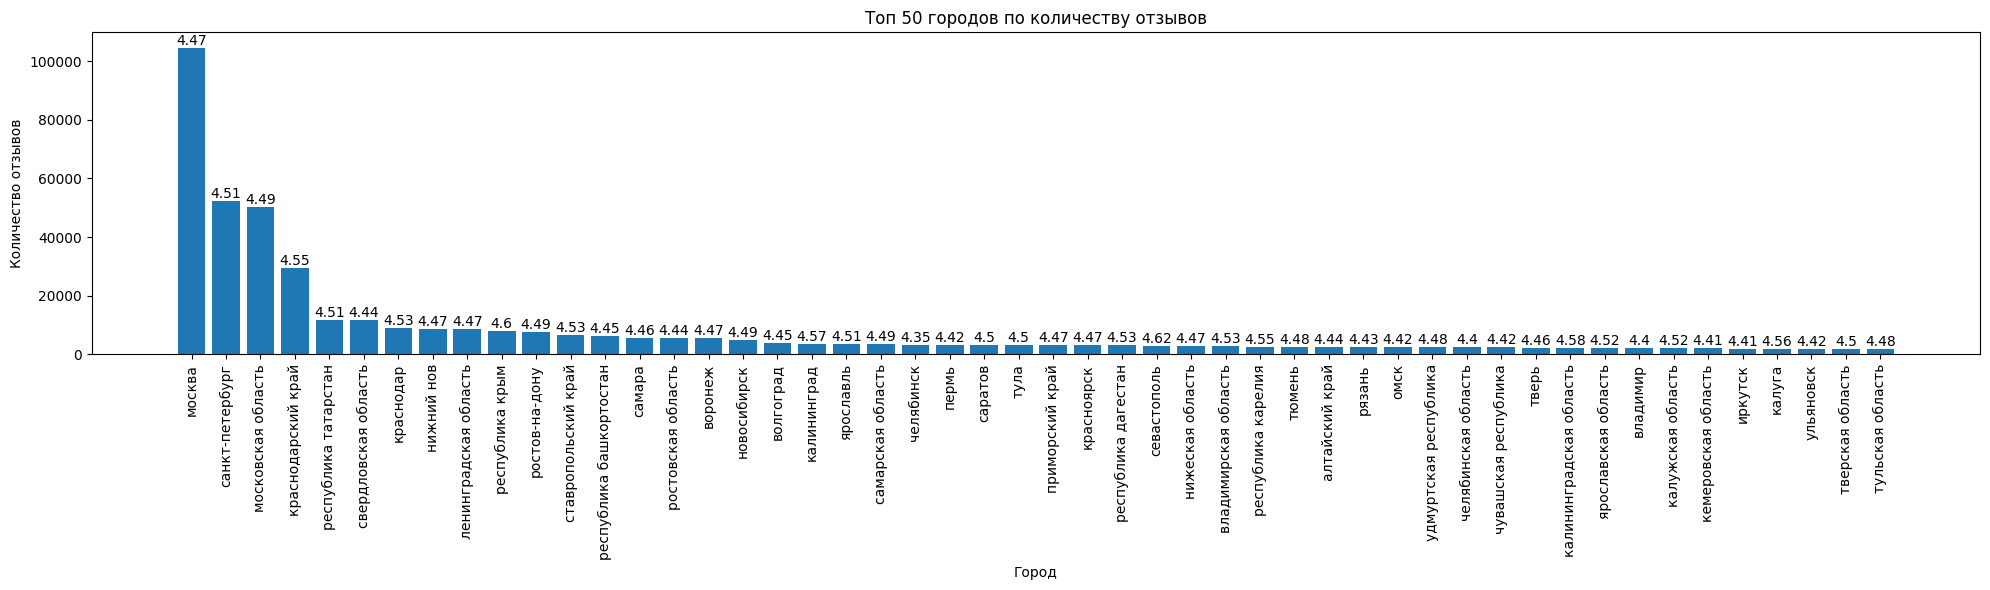

In [35]:
city_counts = df.groupby('city')['rating'].agg(['mean', 'count']).sort_values(by = 'count', ascending=False)
city_counts
number_places = 50

plt.figure(figsize=(20, 6))
bars = plt.bar(city_counts.index[:number_places], city_counts['count'][:number_places])
plt.xlabel('Город')
plt.ylabel('Количество отзывов')
plt.title(f'Топ {number_places} городов по количеству отзывов')

for bar, count in zip(bars, city_counts['mean'][:number_places]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(count,2)), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [36]:
print('Средний рейтинг отзыва: ', df.groupby('city')['rating'].mean().mean())

Средний рейтинг отзыва:  4.422973221924731


Вывод: 

1. Практически все города из топа по количеству имеют отызвы выше среднего.
2. Города из топов имеют близкие среднее отзывов

### Топ городов с лучшим рейтингами



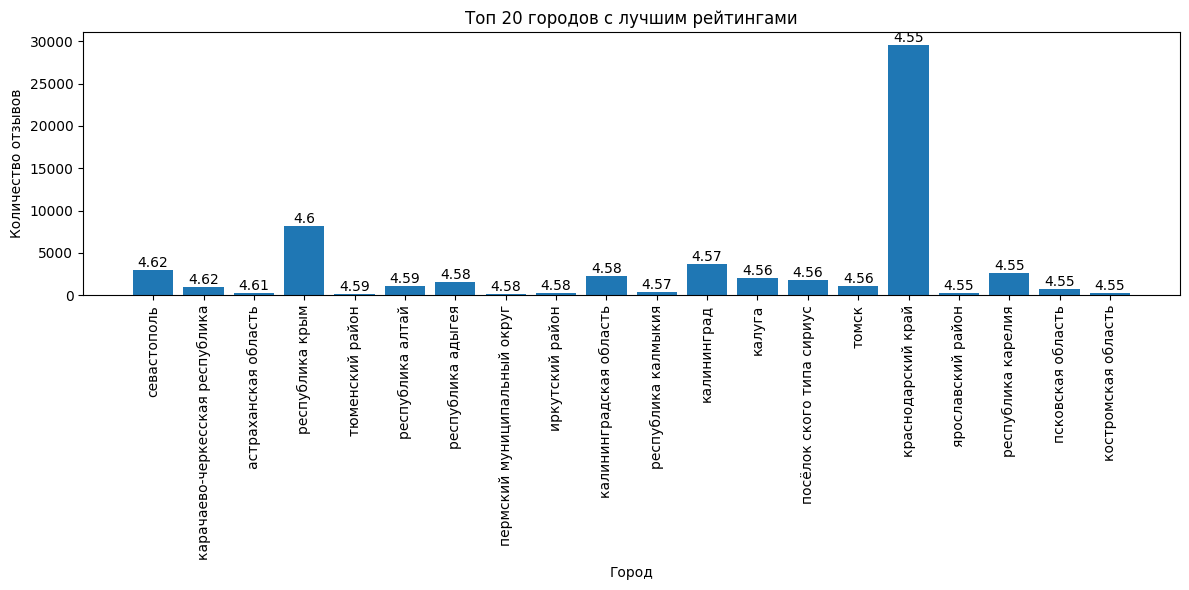

In [37]:
min_reviews = 100
number_places = 20

cities = df.groupby('city').count()['text'].sort_values(ascending=False)
cities = cities[cities.values > min_reviews].index

cities = df[(df['city'].isin(cities))]
cities

city_counts = cities.groupby('city')['rating'].agg(['mean', 'count'])
city_counts = city_counts.sort_values(by=['mean', 'count'], ascending=False)[:number_places]
city_counts



plt.figure(figsize=(12, 6))
bars = plt.bar(city_counts.index, city_counts['count'])
plt.xlabel('Город')
plt.ylabel('Количество отзывов')
plt.title(f'Топ {number_places} городов с лучшим рейтингами')

for bar, count in zip(bars, city_counts['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(count,2)), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Вывод: люди у моря счастливые :) . Отзывы о хороших гостиницах повлияли.

### Топ городов с плохими рейтингами


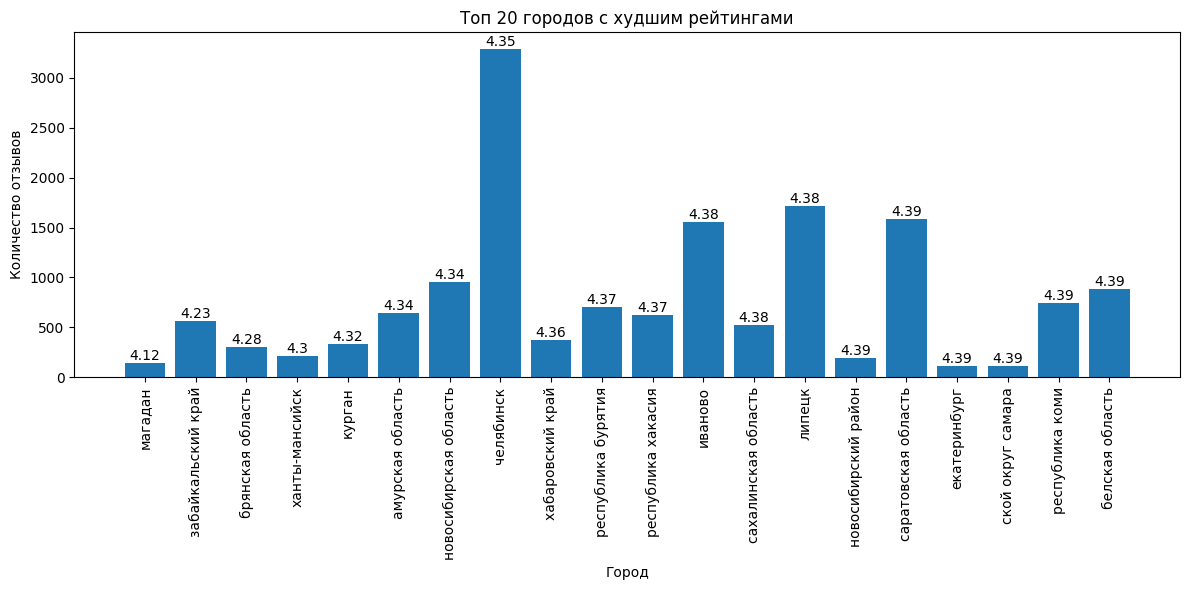

In [38]:
min_reviews = 100
number_places = 20

cities = df.groupby('city').count()['text'].sort_values(ascending=False)
cities = cities[cities.values > min_reviews].index

cities = df[(df['city'].isin(cities))]
cities

city_counts = cities.groupby('city')['rating'].agg(['mean', 'count'])
city_counts = city_counts.sort_values(by=['mean', 'count'])[:number_places]
city_counts



plt.figure(figsize=(12, 6))
bars = plt.bar(city_counts.index, city_counts['count'])
plt.xlabel('Город')
plt.ylabel('Количество отзывов')
plt.title(f'Топ {number_places} городов с худшим рейтингами')

for bar, count in zip(bars, city_counts['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(count,2)), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Пустые значения

In [39]:
def get_df_null(df: pd.DataFrame) -> None:
    plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
    plt.title("Null values")

    plt.xlabel("Columns")
    plt.ylabel("Rows")

    plt.xticks(range(len(df.columns)),df.columns)
    plt.show()
    print(df.isna().sum())

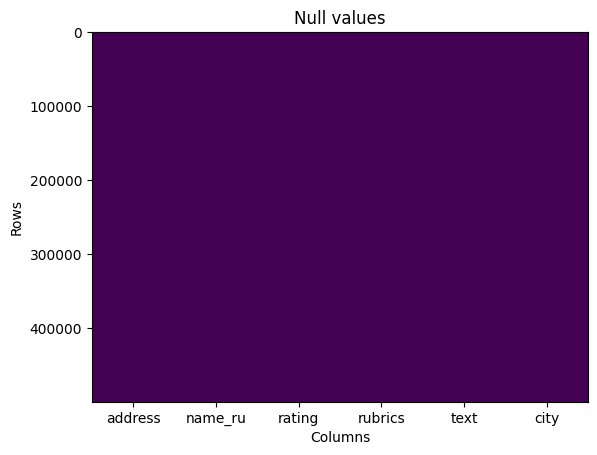

address    0
name_ru    0
rating     0
rubrics    0
text       0
city       0
dtype: int64


In [40]:
get_df_null(df)

name_ru - не будет учитываься в обучении 

### Уникальные значения

<Axes: title={'center': 'Unique values per feature'}>

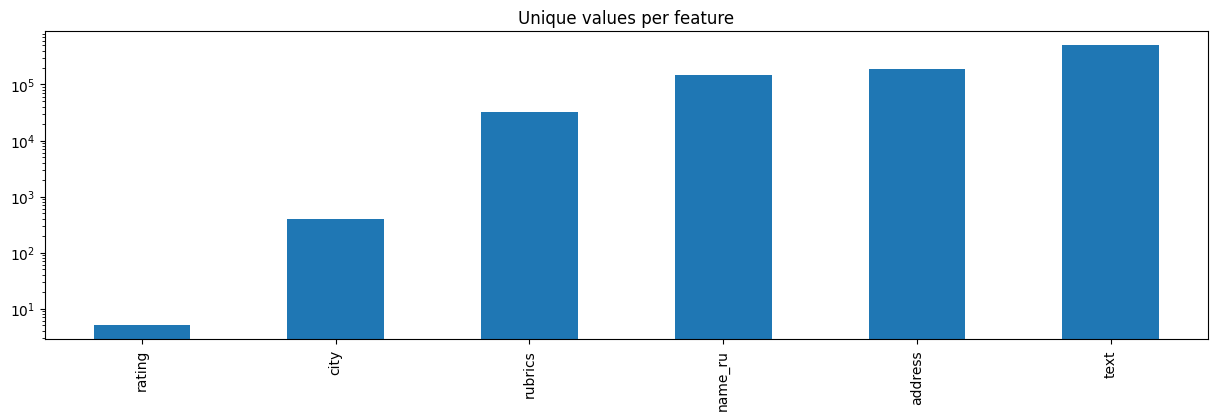

In [41]:
unique_values = df.nunique().sort_values()

unique_values.plot.bar(logy=True, figsize=(
    15, 4), title="Unique values per feature")

### Вывод

* Данные хорошие. И теперь готовы к обучению.

## Обработка текста

### Удаление лишних столбцов

In [42]:
df.drop(["address","name_ru","rubrics","city"], inplace = True, axis = 1)
df

,rating,text
0,3,Московский квартал 2.\nШумно : летом по ночам ...
1,5,"Замечательная сеть магазинов в общем, хороший ..."
2,1,"Не знаю смутят ли кого-то данные правила, но я..."
3,4,Хорошие условия аренды. \nДружелюбный персонал...
4,5,Топ мастер Ангелина топ во всех смыслах ) Немн...
...,...,...
499994,5,Хороший способ избежать автобусной пытки. Элек...
499995,4,"Охрана кривая но добрая, двери не закрываются ..."
499996,4,По сравнению со многими современными платформа...
499998,5,Был с семьёй 13.06.23 Отличное место. Рекоменд...


Пробуем обучить только на отзыве

### Очистка отзывов

In [43]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: re.sub(r'[^а-яА-ЯёЁ ]', '', x))
df['text'] = df['text'].apply(lambda x: re.sub('\\s+[a-zA-Z]\\s+', '', x))

df

,rating,text
0,3,московский квартал шумно летом по ночам дикие...
1,5,замечательная сеть магазинов в общем хороший а...
2,1,не знаю смутят ли когото данные правила но я б...
3,4,хорошие условия аренды дружелюбный персонално ...
4,5,топ мастер ангелина топ во всех смыслах немно...
...,...,...
499994,5,хороший способ избежать автобусной пытки элект...
499995,4,охрана кривая но добрая двери не закрываются а...
499996,4,по сравнению со многими современными платформа...
499998,5,был с семьёй отличное место рекомендую это ко...


### Токенизация

In [44]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
tqdm.pandas()

df['text'] = df['text'].progress_apply(lambda x: word_tokenize(x, language='russian'))

100%|██████████| 498829/498829 [03:52<00:00, 2140.97it/s]


### Удаление стоп-слов

In [46]:
stop_words = set(stopwords.words('russian'))

In [47]:
df['text'] = df['text'].apply(lambda tokens: ' '.join(tokens))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df

,rating,text
0,3,московский квартал шумно летом ночам дикие гон...
1,5,замечательная сеть магазинов общем хороший асс...
2,1,знаю смутят когото данные правила удивлена хоч...
3,4,хорошие условия аренды дружелюбный персонално ...
4,5,топ мастер ангелина топ смыслах немного волнов...
...,...,...
499994,5,хороший способ избежать автобусной пытки элект...
499995,4,охрана кривая добрая двери закрываются автомат...
499996,4,сравнению многими современными платформами эпо...
499998,5,семьёй отличное место рекомендую это настоящий...


### Лемматизации

In [48]:
morph = pymorphy2.MorphAnalyzer()


def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    lemmatized_text = " ".join(lemmatized_words)
    return lemmatized_text

In [50]:
tqdm.pandas()

df['text'] = df['text'].progress_apply(lemmatize_text)

In [ ]:
df.to_csv('lem_500kdata.csv')

In [6]:
df = pd.read_csv('/kaggle/input/sentimentanalysisyandexreviews/lem_500kdata.csv')

In [7]:
df

,Unnamed: 0,rating,text
0,0,3,московский квартал шумно лето ночь дикий гонка...
1,1,5,замечательный сеть магазин общий хороший ассор...
2,2,1,знать смутить коготь дать правило удивить хоте...
3,3,4,хороший условие аренда дружелюбный персонално ...
4,4,5,топ мастер ангелина топ смысл немного волноват...
...,...,...,...
498824,499994,5,хороший способ избежать автобусный пытка элект...
498825,499995,4,охрана кривая добрый дверь закрываться автомат...
498826,499996,4,сравнение многий современный платформа эпоха с...
498827,499998,5,семья отличный место рекомендовать это настоящ...


## Облако слов

#### Облако словосочетаний для `rating`  == 5

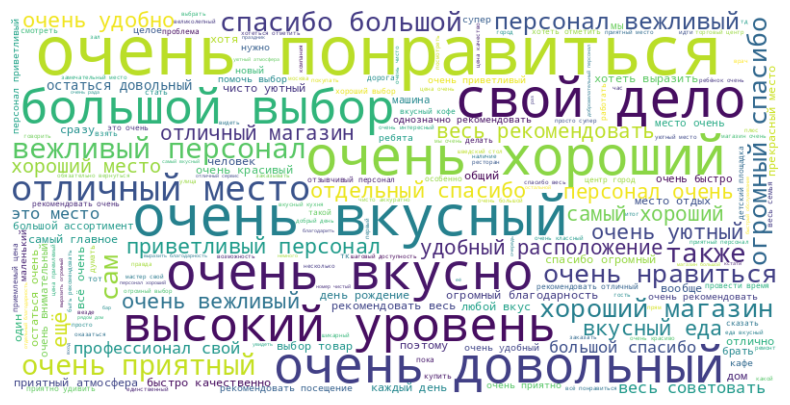

In [53]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df[df['rating'] == 5]['text'].astype(str)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Облако слов для `rating` ==  5

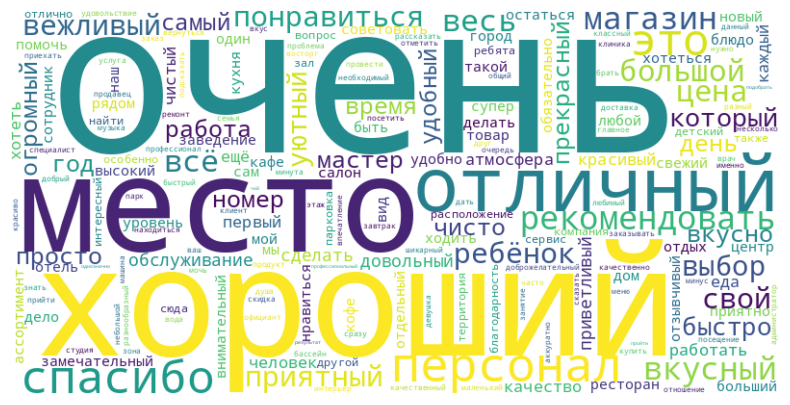

In [54]:
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate( " ".join(df[df['rating'] == 5]['text'].astype(str)))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Облако слов и словосочетаний для `rating`  == 1

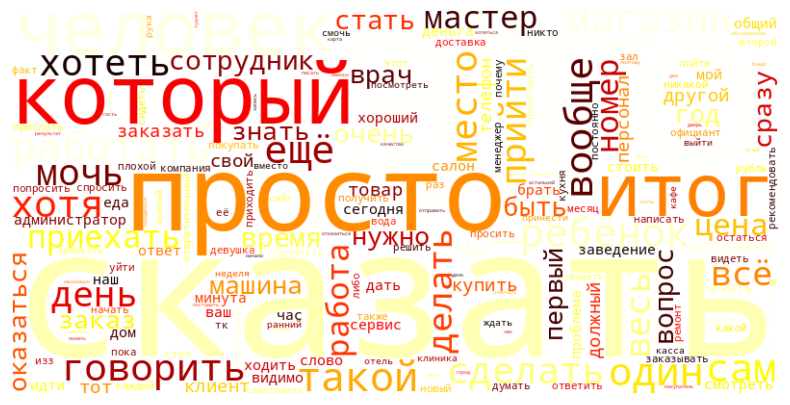

In [55]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='hot').generate( " ".join(df[df['rating'] == 1]['text'].astype(str)))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Это то, что получилось у Яндекс, но у них данные с 2022 - 2023 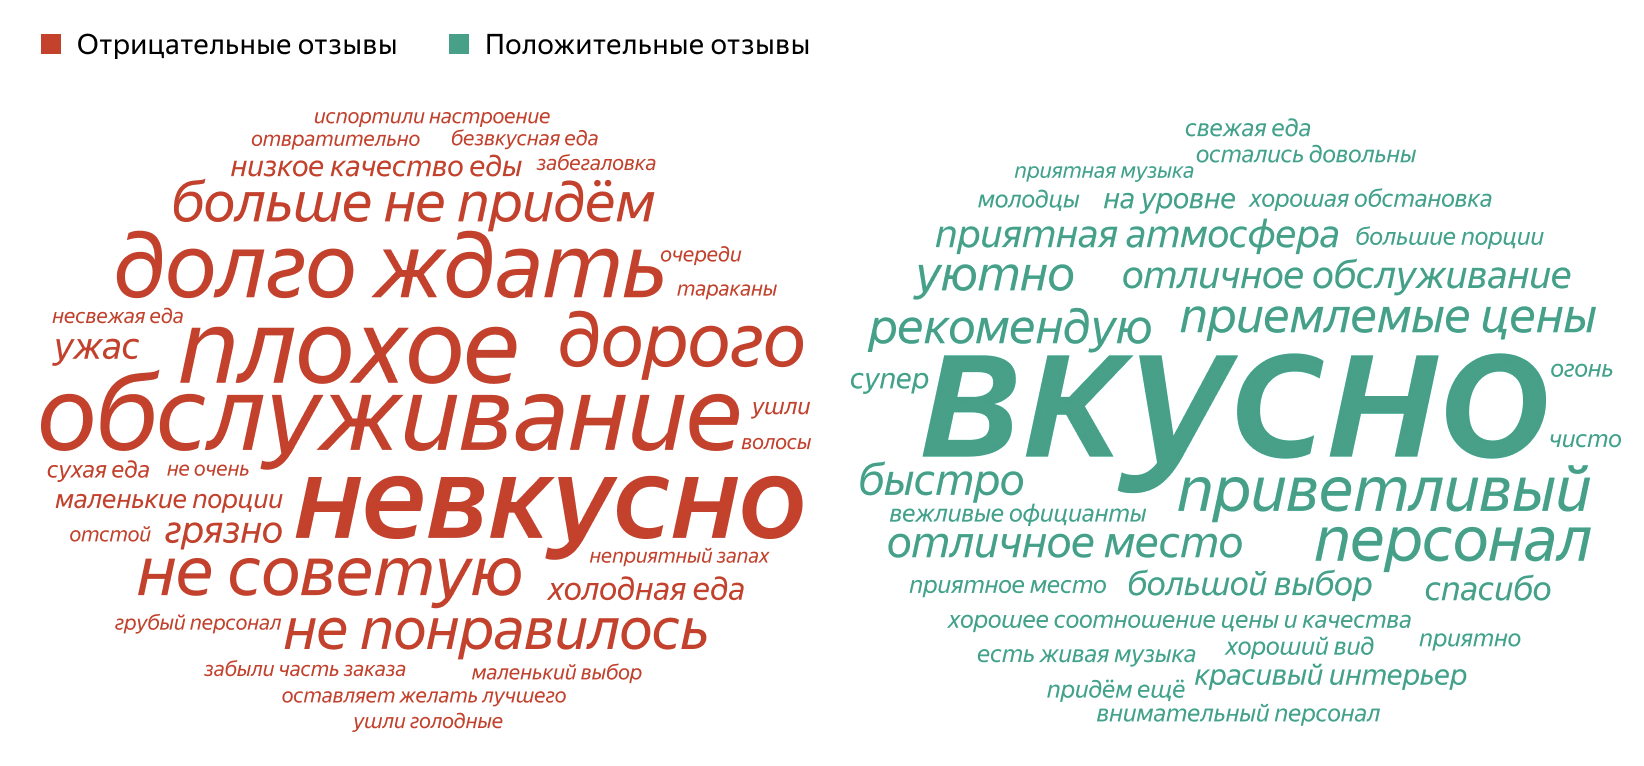

Вывод: облако слов у положительных отзывов лучше. Думаю это связано с тем, что люди при написании положительного отзыва просто и кратко хвалят место. Вкусно, хорошо и тд. В отрицательных отзывах может быть все что угодно, описание плохо оказаной услуги, ругательства, у всех разные слова для описания низкого сервиса. Так что в облаке слов больше общие слова.